## setup

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
# import warnings
# warnings.filterwarnings('ignore')
# %matplotlib inline

import cv2
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

/home/raphaelpeabody/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-05-13 02:21:36.412101: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 02:21:36.444846: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compile

In [2]:
data = "/home/raphaelpeabody/Downloads/UTKFace"

In [3]:
image_paths = []
age_labels = []
gender_labels = []
race_labels = []

for filename in tqdm(os.listdir(data)):
    image_path = os.path.join(data, filename)
    try:
        temp = filename.split('_')
        age = int(temp[0])
        gender = int(temp[1])
        race = int(temp[2])
    except ValueError:
        print("Skipping file:", filename)
        continue
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)



  0%|          | 0/23709 [00:00<?, ?it/s]

Skipping file: rename.bash
Skipping file: 39_1_20170116174525125.jpg
Skipping file: 61_1_20170109150557335.jpg
Skipping file: 61_1_20170109142408075.jpg


In [4]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race'] = image_paths, age_labels, gender_labels, race_labels
df.head()

,image,age,gender,race
0,/home/raphaelpeabody/Downloads/UTKFace/7_1_4_2...,7,1,4
1,/home/raphaelpeabody/Downloads/UTKFace/26_1_0_...,26,1,0
2,/home/raphaelpeabody/Downloads/UTKFace/18_1_0_...,18,1,0
3,/home/raphaelpeabody/Downloads/UTKFace/22_1_3_...,22,1,3
4,/home/raphaelpeabody/Downloads/UTKFace/28_1_0_...,28,1,0


In [5]:
gender_dict = {0:'Male', 1:'Female'}
race_dict = {0:'White', 1:'Black', 2:'Asian', 3:'Indian', 4:'Other'}

Image Shape:  (200, 200, 3)


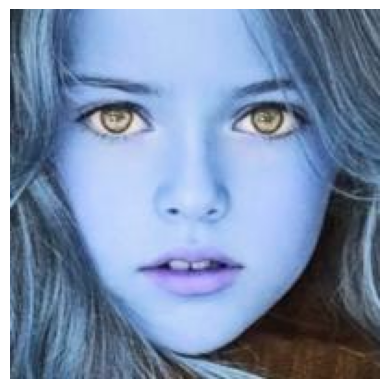

In [6]:
img = cv2.imread(os.path.join(data, '10_1_0_20170109204617417.jpg'))
plt.axis('off')
plt.imshow(img)
print('Image Shape: ',img.shape)

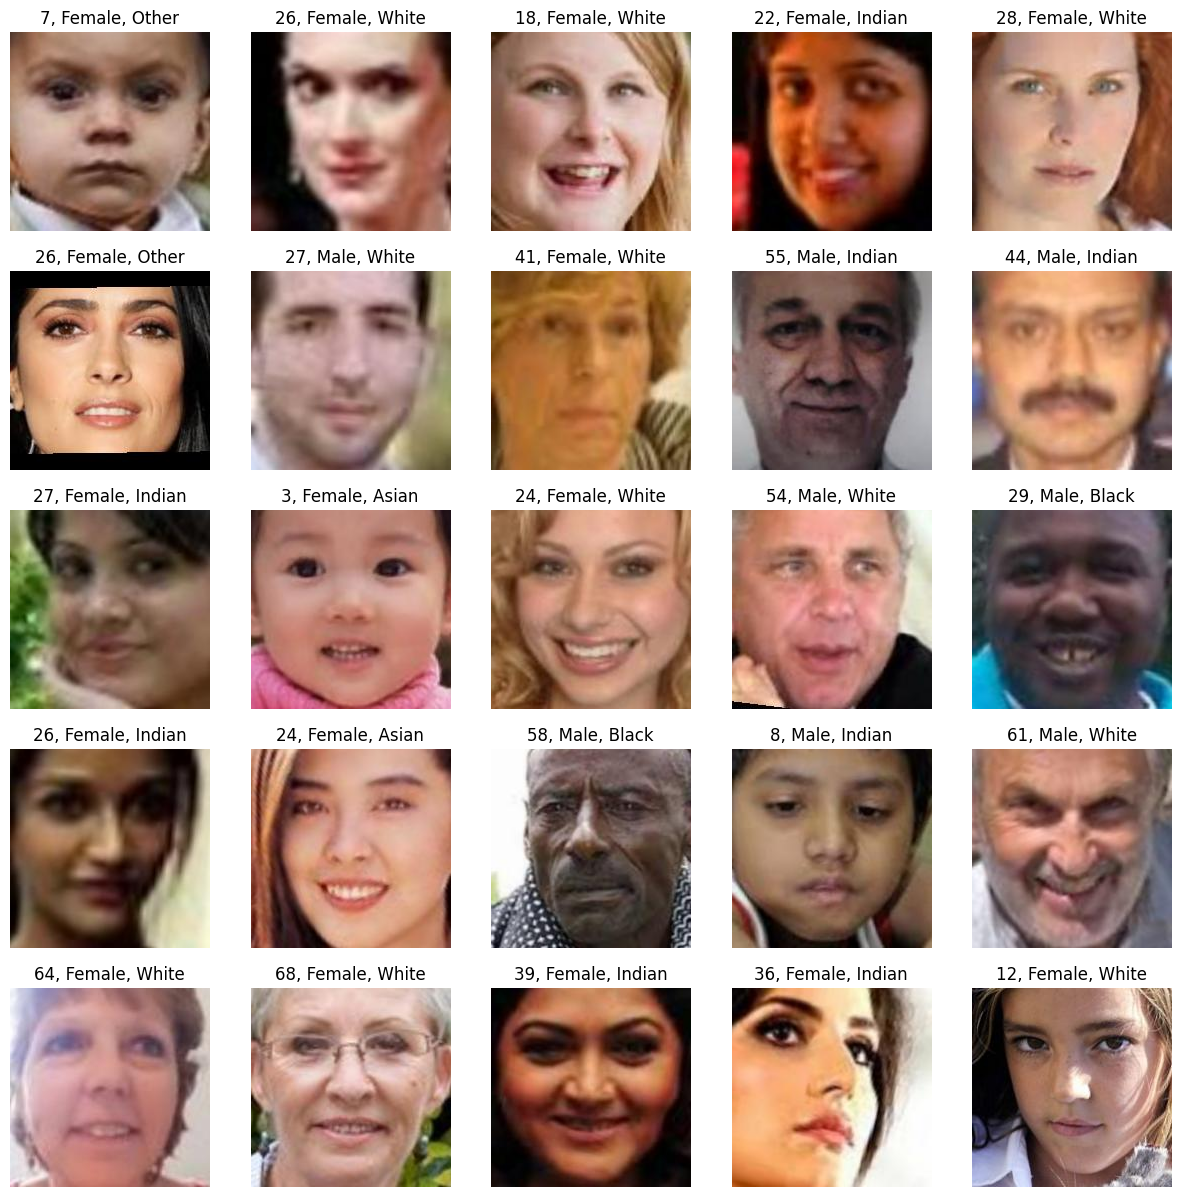

In [7]:
# Display grid/multiple images

plt.figure(figsize=(15,15))
files = df.iloc[0:25]

for index, file, age, gender, race in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f'{age}, {gender_dict[gender]}, {race_dict[race]}')
    plt.axis('off')

## feature extraction

In [8]:
from PIL import Image

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image).convert('L')  # Open image and convert to grayscale
        img = img.resize((128, 128), Image.ANTIALIAS)  # Resize image
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [9]:
X_raw = extract_features(df['image'])


  0%|          | 0/23705 [00:00<?, ?it/s]

/tmp/ipykernel_17047/1317117716.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((128, 128), Image.ANTIALIAS)  # Resize image


In [12]:
print(X_raw.shape)

(23705, 128, 128, 1)


In [13]:
X = X_raw/255.0

np.save('X', X)

In [14]:
X = np.load('X.npy')

## model setup

In [15]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
y_race = np.array(df['race'])

In [16]:
input_shape = (128,128,1)

In [17]:
inputs = Input((input_shape))

conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)

conv_2 = Conv2D(32, kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)

conv_3 = Conv2D(32, kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)

conv_4 = Conv2D(32, kernel_size=(3,3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

flatten = Flatten()(maxp_4)

# Fully connected layers
dense_1 = Dense(256, activation = 'relu')(flatten)
dense_2 = Dense(256, activation = 'relu')(flatten)
# dense_3 = Dense(256, activation = 'relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)
# dropout_3 = Dropout(0.3)(dense_3)

# output_1 = Dense(1, activation = 'sigmoid', name = 'gender_out')(dropout_1)
output_2 = Dense(1, activation = 'relu', name = 'age_out')(dropout_2)
# output_3 = Dense(1, activation = 'relu', name = 'race_out')(dropout_3)

# model = Model(inputs = [inputs], outputs = [output_1, output_2, output_3])
# model = Model(inputs = [inputs], outputs = [output_1, output_2])
model = Model(inputs = [inputs], outputs = [output_2])

model.compile(loss = ['binary_crossentropy', 'mae'], optimizer = 'adam', metrics = ['accuracy','mae'])

2024-05-13 02:25:37.080403: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-13 02:25:37.164206: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │      9,248 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │      9,248 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │      9,248 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 32)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1152)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    295,168 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    295,168 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 618,914 (2.36 MB)

 Trainable params: 618,914 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

## training

In [19]:
history = model.fit(x = X, y = [y_gender, y_age, y_race], batch_size=32, epochs = 30, validation_split = 0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 45s 74ms/step - age_out_mae: 17.1462 - gender_out_accuracy: 0.5363 - loss: 17.8462 - val_age_out_mae: 13.7267 - val_gender_out_accuracy: 0.7015 - val_loss: 14.2992
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - age_out_mae: 12.7276 - gender_out_accuracy: 0.7271 - loss: 13.2823 - val_age_out_mae: 11.5619 - val_gender_out_accuracy: 0.7598 - val_loss: 12.0371
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - age_out_mae: 11.0044 - gender_out_accuracy: 0.7785 - loss: 11.4679 - val_age_out_mae: 10.6296 - val_gender_out_accuracy: 0.7545 - val_loss: 11.1146
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - age_out_mae: 10.2397 - gender_out_accuracy: 0.7890 - loss: 10.6817 - val_age_out_mae: 9.1976 - val_gender_out_accuracy: 0.8022 - val_loss: 9.6244
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - age_out_mae: 9.4650 - gender_out_accuracy: 0.7969 - loss: 9.8929 - val_age_out_mae: 8.7219 - val_gender_out_accuracy: 0.8197 - val

<Figure size 640x480 with 0 Axes>

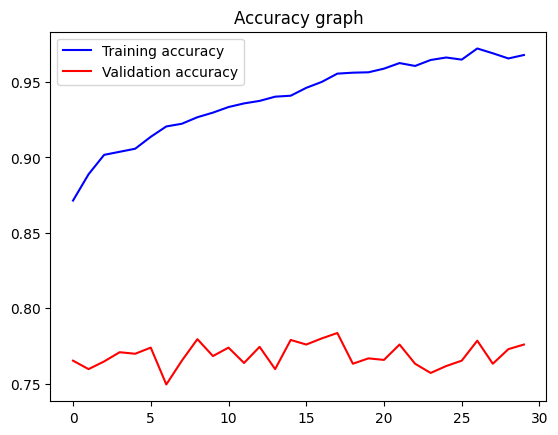

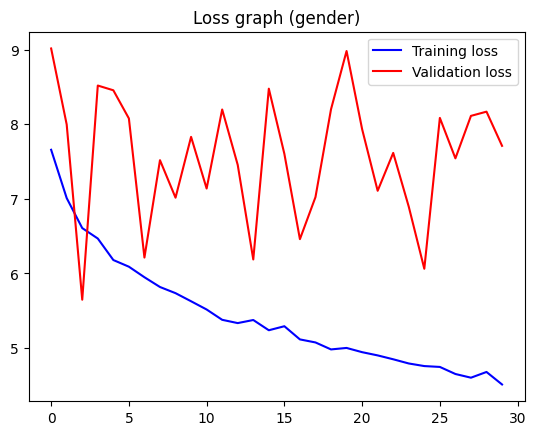

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Accuracy graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Loss graph (gender)')
plt.legend()
plt.figure()

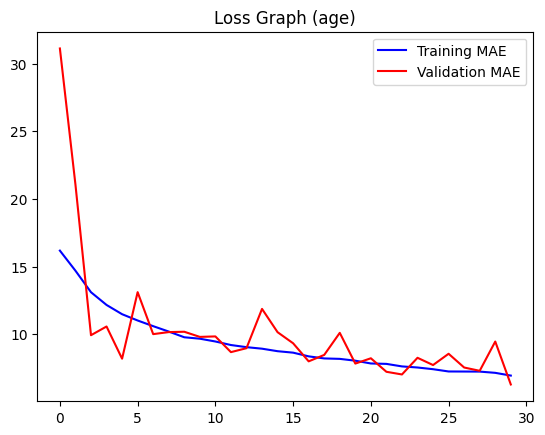

In [ ]:
# Plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph (age)')
plt.legend()
plt.show()

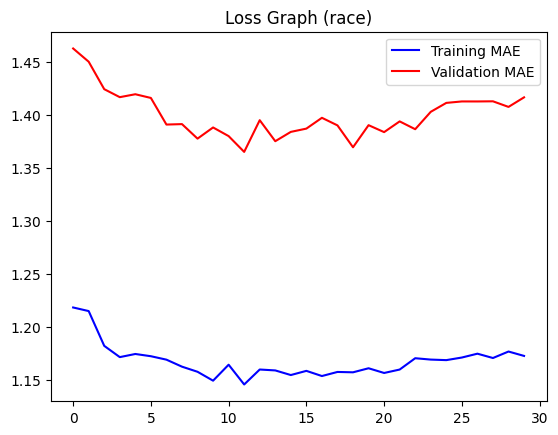

In [ ]:
# Plot results for race
loss = history.history['race_out_mae']
val_loss = history.history['val_race_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph (race)')
plt.legend()
plt.show()

In [ ]:
history = model.fit(x = X, y = [y_gender, y_age], batch_size=32, epochs = 30, validation_split = 0.2)

Epoch 1/30
246/246 [==============================] - 7s 18ms/step - loss: 16.8502 - gender_out_loss: 0.6917 - age_out_loss: 16.1585 - gender_out_accuracy: 0.5512 - gender_out_mae: 0.4879 - age_out_accuracy: 0.0000e+00 - age_out_mae: 16.1585 - val_loss: 28.8540 - val_gender_out_loss: 0.6923 - val_age_out_loss: 28.1617 - val_gender_out_accuracy: 0.5132 - val_gender_out_mae: 0.4939 - val_age_out_accuracy: 0.2419 - val_age_out_mae: 28.1617
Epoch 2/30
246/246 [==============================] - 4s 18ms/step - loss: 14.9411 - gender_out_loss: 0.6279 - age_out_loss: 14.3132 - gender_out_accuracy: 0.6349 - gender_out_mae: 0.4344 - age_out_accuracy: 0.0000e+00 - age_out_mae: 14.3132 - val_loss: 15.4995 - val_gender_out_loss: 0.6017 - val_age_out_loss: 14.8978 - val_gender_out_accuracy: 0.6634 - val_gender_out_mae: 0.4183 - val_age_out_accuracy: 0.2419 - val_age_out_mae: 14.8978
Epoch 3/30
246/246 [==============================] - 4s 17ms/step - loss: 13.4587 - gender_out_loss: 0.5138 - age_out

<Figure size 640x480 with 0 Axes>

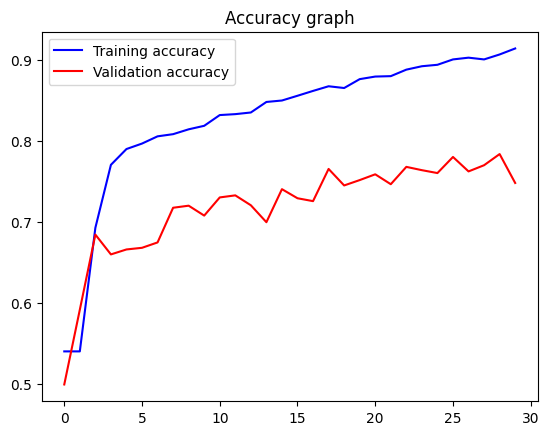

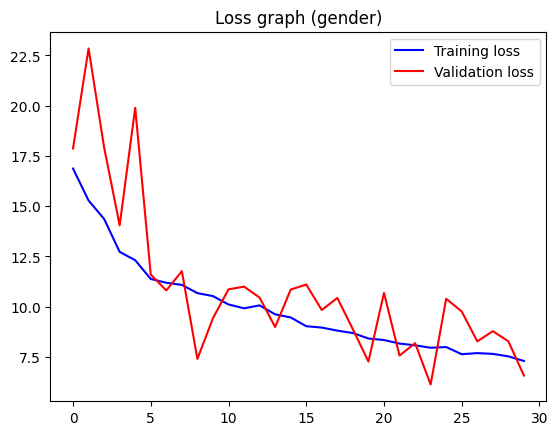

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Accuracy graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Loss graph (gender)')
plt.legend()
plt.figure()

Original Gender: Male Original Age: 70
1/1 [==============================] - 1s 578ms/step
Predicted Gender: Male Predicted Age: 61


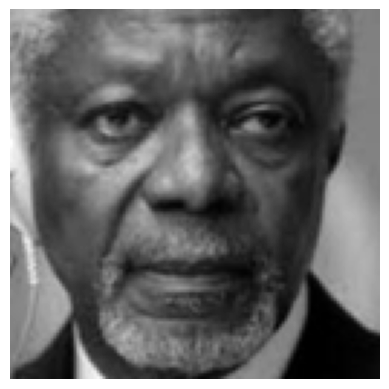

In [ ]:
image_index = 103
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 11
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Female Predicted Age: 6


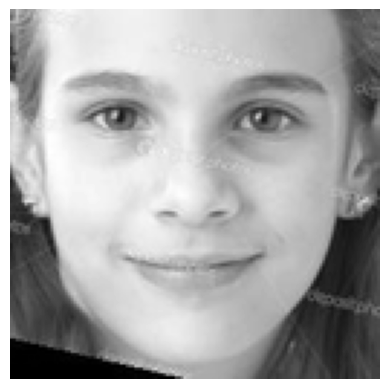

In [ ]:
image_index = 9000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

gender
0    5156
1    4663
Name: count, dtype: int64


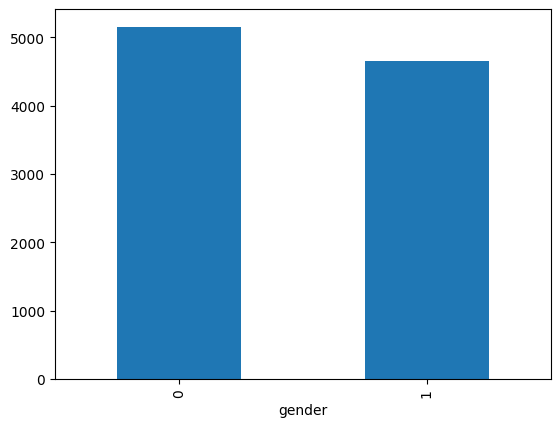

In [ ]:
print(df['gender'].value_counts())
df['gender'].value_counts().plot(kind='bar');

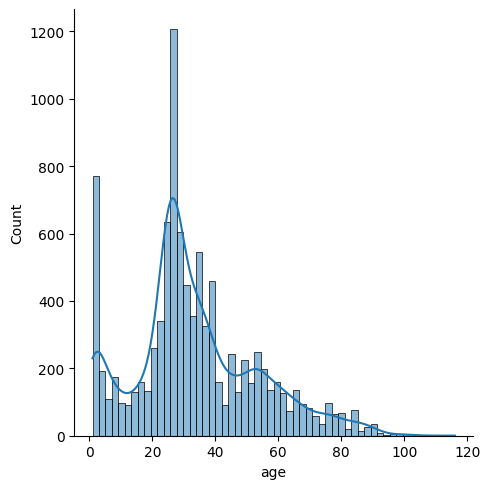

In [ ]:
sns.displot(df['age'],kde = True);

In [ ]:
race_counts = df['race'].value_counts()
print(race_counts)

race
0    4201
1    1863
3    1642
2    1392
4     721
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import accuracy_score, mean_absolute_error

# Separate predictions and true age labels based on racial groups
predictions_by_race = {}
true_ages_by_race = {}

for race in race_dict.values():
    indices = [i for i, r in enumerate(race_labels) if r == race]
    predictions_by_race[race] = rounded_predicted_ages[indices]
    true_ages_by_race[race] = y_age[indices]

# Calculate performance metrics for age prediction separately for each racial group
performance_metrics_by_race = {}

for race in race_dict.values():
    print(race)
    predictions_race = predictions_by_race[race]
    true_ages_race = true_ages_by_race[race]

    accuracy = accuracy_score(true_ages_race, predictions_race)
    mae = mean_absolute_error(true_ages_race, predictions_race)

    performance_metrics_by_race[race] = {'Accuracy': accuracy, 'MAE': mae}

# Visualize or compare performance metrics across different racial groups
for race, metrics in performance_metrics_by_race.items():
    print(f"Race: {race}")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"Mean Absolute Error: {metrics['MAE']}")
    print()


White
Black
Asian
Indian
Other
Race: White
Accuracy: 0.04498928826469888
Mean Absolute Error: 7.6367531540109495

Race: Black
Accuracy: 0.062265163714439076
Mean Absolute Error: 6.520665593129361

Race: Asian
Accuracy: 0.0639367816091954
Mean Absolute Error: 5.541666666666667

Race: Indian
Accuracy: 0.05602923264311815
Mean Absolute Error: 6.161997563946406

Race: Other
Accuracy: 0.06796116504854369
Mean Absolute Error: 4.969486823855756



In [ ]:
from sklearn.metrics import mean_absolute_error
from scipy import stats

# Dictionary to store MAE for each race
mae_per_race = {}

# Split the dataset based on race
unique_races = np.unique(y_race)
for race in unique_races:
    race_indices = np.where(y_race == race)[0]
    X_race = X[race_indices]
    y_age_race = y_age[race_indices]

    # Train a model for each race
    model_race = Model(inputs=[inputs], outputs=[output_2])  # Model for age prediction
    model_race.compile(loss='mae', optimizer='adam', metrics=['mae'])
    history_race = model_race.fit(x=X_race, y=y_age_race, batch_size=32, epochs=30, validation_split=0.2, verbose=0)

    # Evaluate the model and calculate MAE
    y_pred_race = model_race.predict(X_race)
    mae_race = mean_absolute_error(y_age_race, y_pred_race)
    mae_per_race[race_dict[race]] = mae_race

# Print MAE for each race
for race, mae in mae_per_race.items():
    print(f"MAE for {race}: {mae}")


23/23 [==============================] - 0s 4ms/step
MAE for White: 4.951209629385053
MAE for Black: 3.9087982719071244
MAE for Asian: 3.661222226746466
MAE for Indian: 3.5406396573048706
MAE for Other: 2.9258152335758183


4201
4201
Race: White
Number of samples: 4201


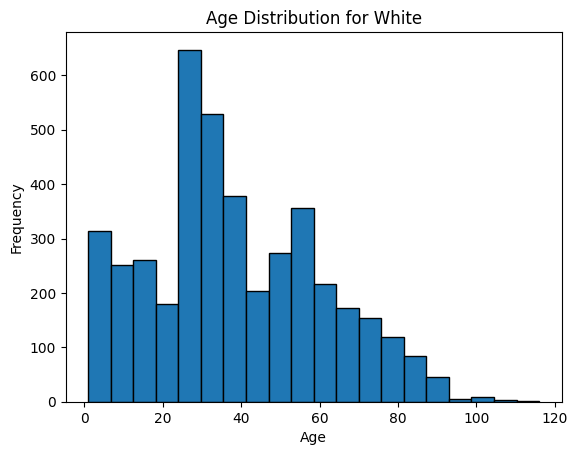

1863
1863
Race: Black
Number of samples: 1863


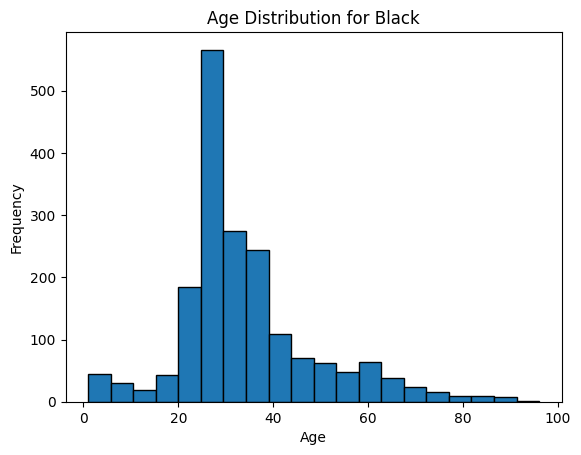

1392
1392
Race: Asian
Number of samples: 1392


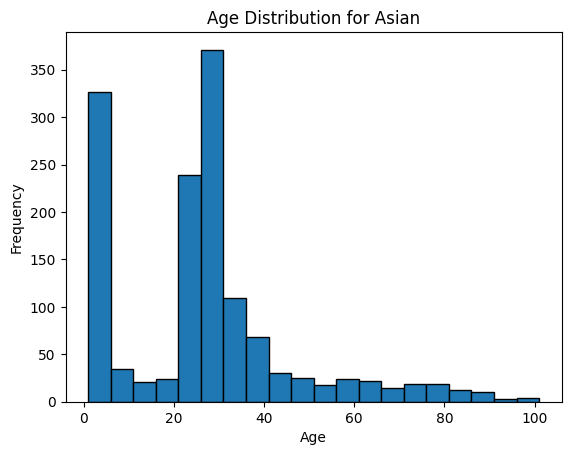

1642
1642
Race: Indian
Number of samples: 1642


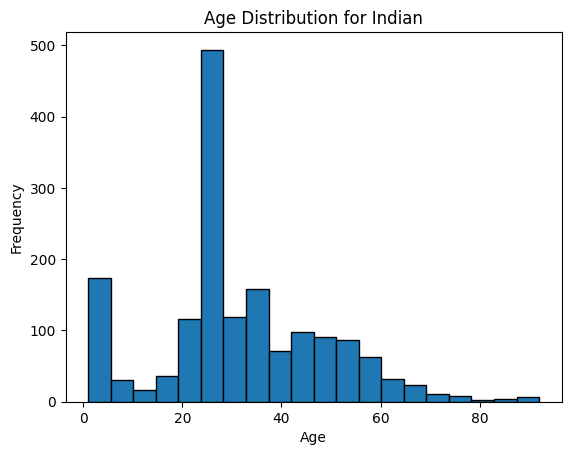

721
721
Race: Other
Number of samples: 721


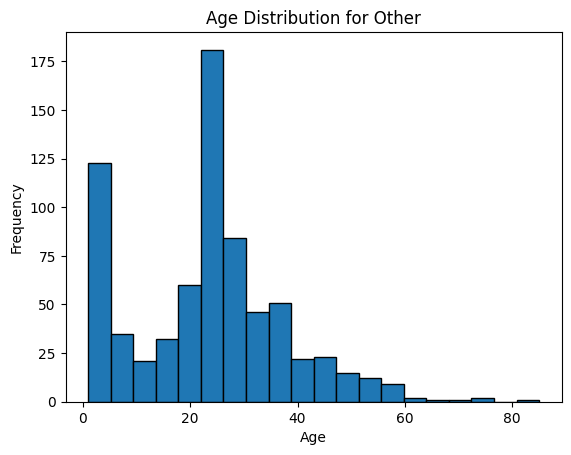

In [ ]:
from sklearn.model_selection import train_test_split

# Dictionary to store datasets for each race
datasets_per_race = {}

# Split the dataset based on race
unique_races = np.unique(y_race)
for race in race_dict:
    race_indices = np.where(y_race == race)[0]
    X_race = X[race_indices]
    y_age_race = y_age[race_indices]
    print(len(X_race))
    print(len(y_age_race))
    # Split the race dataset into train and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X_race, y_age_race, test_size=0.2, random_state=42)

    print(f"Race: {race_dict[race]}")
    print(f"Number of samples: {len(X_race)}")

    # Plot the age distribution for each race
    plt.figure()
    plt.hist(y_age_race, bins=20, edgecolor='black')
    plt.title(f"Age Distribution for {race_dict[race]}")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.show()


    datasets_per_race[race_dict[race]] = {'X': X_race, 'y': y_age_race}

In [ ]:
# Calculate MAE for each race dataset using the original model
mae_per_race_dataset = {}
for race, data in datasets_per_race.items():
    X_test_race = data['X']
    y_test_race = data['y']

    # Predict age using the original model
    # pred = model.predict(X_test_race)[1]  # Index 1 for age predictions
    y_pred_race = round(pred[1][0][0])
    # print(pred[1])
    # print(y_test_race)
    # Calculate MAE
    mae_race = mean_absolute_error(y_test_race, y_pred_race)
    mae_per_race_dataset[race] = mae_race

# Print MAE for each race dataset
for race, mae in mae_per_race_dataset.items():
    print(f"MAE for {race}: {mae}")

132/132 [==============================] - 1s 8ms/step


IndexError: invalid index to scalar variable.

In [ ]:
from sklearn.metrics import mean_absolute_error
from scipy import stats
# Calculate MAE for each race dataset using the original model
mae_per_race_dataset = {}
for race, data in datasets_per_race.items():
    X_test_race = data['X']
    y_test_race = data['y']

    # Predict age using the original model
    y_pred_race = model.predict(X_test_race)[1]  # Index 1 for age predictions

    # Calculate MAE
    mae_race = mean_absolute_error(y_test_race, y_pred_race)
    mae_per_race_dataset[race] = mae_race

# Print MAE for each race dataset
for race, mae in mae_per_race_dataset.items():
    print(f"MAE for {race}: {mae}")

23/23 [==============================] - 0s 14ms/step
MAE for White: 7.185734100595482
MAE for Black: 6.243974200257421
MAE for Asian: 4.999987276463673
MAE for Indian: 5.858508874670161
MAE for Other: 5.060042800751209


balance the age distributions within each race

oversample to match the white people distribution and randomly augment when oversampling



In [ ]:
pip install imbalanced-learn

In [ ]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Define a function to balance the age distributions within each race
def balance_age_distributions(datasets_per_race):
    # Get the age distribution of the white race group (race == 0)
    white_race_age_distribution = Counter(datasets_per_race['White']['y'])

    # Iterate over each race group
    for race, data in datasets_per_race.items():
        X_race = data['X']
        y_age_race = data['y']

        # Check if the current race group is not the white race group
        if race != 'White':
            # Get the age distribution of the current race group
            race_age_distribution = Counter(y_age_race)

            # Calculate the oversampling/undersampling ratio
            oversample_ratio = {
                age: white_race_age_distribution[age] / race_age_distribution.get(age, 1)
                for age in set(white_race_age_distribution.keys()) | set(race_age_distribution.keys())
            }

            # Perform random oversampling or undersampling to balance the age distribution
            if max(oversample_ratio.values()) > 1:
                ros = RandomOverSampler(sampling_strategy=oversample_ratio, random_state=42)
                X_resampled, y_resampled = ros.fit_resample(X_race, y_age_race)
            else:
                rus = RandomUnderSampler(sampling_strategy=oversample_ratio, random_state=42)
                X_resampled, y_resampled = rus.fit_resample(X_race, y_age_race)

            # Update the datasets_per_race dictionary with the balanced dataset
            datasets_per_race[race] = {'X': X_resampled, 'y': y_resampled}

    return datasets_per_race

# Call the function to balance the age distributions within each race
balanced_datasets_per_race = balance_age_distributions(datasets_per_race)


ValueError: Found array with dim 4. RandomOverSampler expected <= 2.

## training session 2

In [ ]:
history = model.fit(x = X, y = [y_gender, y_age], batch_size=32, epochs = 30, validation_split = 0.2)

Epoch 1/30
246/246 [==============================] - 13s 24ms/step - loss: 17.3898 - gender_out_loss: 0.6850 - age_out_loss: 16.7048 - gender_out_accuracy: 0.5645 - gender_out_mae: 0.4803 - age_out_accuracy: 0.0000e+00 - age_out_mae: 16.7048 - val_loss: 14.6670 - val_gender_out_loss: 0.6851 - val_age_out_loss: 13.9819 - val_gender_out_accuracy: 0.5891 - val_gender_out_mae: 0.4955 - val_age_out_accuracy: 0.2419 - val_age_out_mae: 13.9819
Epoch 2/30
246/246 [==============================] - 4s 15ms/step - loss: 15.4859 - gender_out_loss: 0.6913 - age_out_loss: 14.7945 - gender_out_accuracy: 0.5299 - gender_out_mae: 0.4960 - age_out_accuracy: 0.0000e+00 - age_out_mae: 14.7945 - val_loss: 25.3862 - val_gender_out_loss: 0.6916 - val_age_out_loss: 24.6947 - val_gender_out_accuracy: 0.4944 - val_gender_out_mae: 0.4991 - val_age_out_accuracy: 0.2419 - val_age_out_mae: 24.6947
Epoch 3/30
246/246 [==============================] - 4s 15ms/step - loss: 15.0647 - gender_out_loss: 0.6759 - age_ou

In [ ]:
model.save('/content/drive/My Drive/Comp Vis Final Proj/alexis_vers/mymodel.h5')

<Figure size 640x480 with 0 Axes>

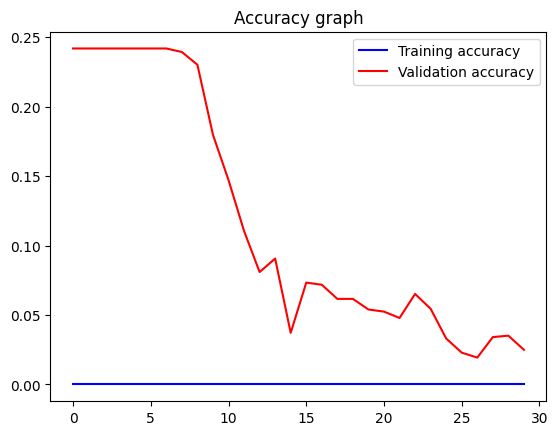

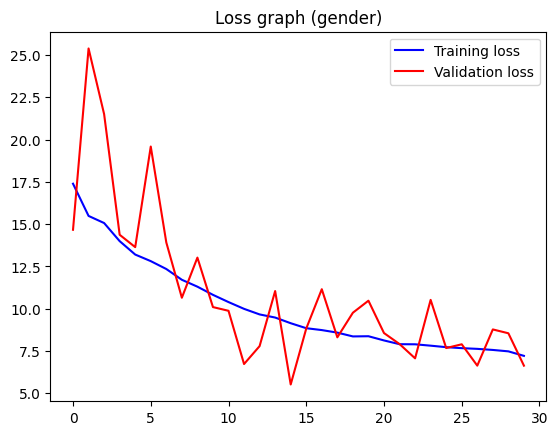

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot results for age
acc = history.history['age_out_accuracy']
val_acc = history.history['val_age_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Accuracy graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Loss graph (gender)')
plt.legend()
plt.figure()

Original Gender: Male Original Age: 70
1/1 [==============================] - 0s 476ms/step
Predicted Gender: Male Predicted Age: 75


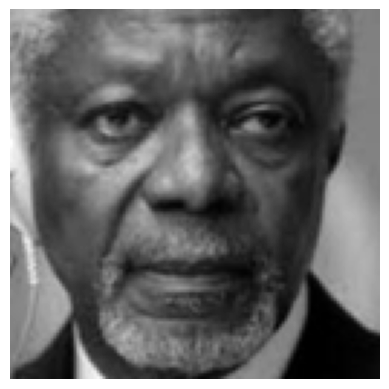

In [ ]:
image_index = 103
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 11
1/1 [==============================] - 0s 32ms/step
Predicted Gender: Female Predicted Age: 17


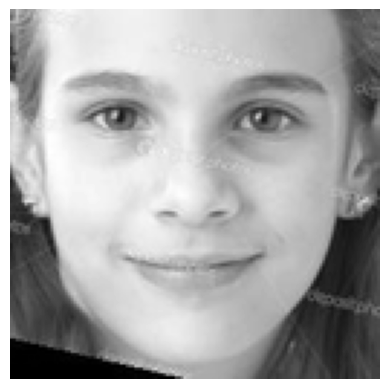

In [ ]:
image_index = 9000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [ ]:
race_counts = df['race'].value_counts()
print(race_counts)

race
0    4201
1    1863
3    1642
2    1392
4     721
Name: count, dtype: int64


In [ ]:
pip install imbalanced-learn

In [ ]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Define a function to balance the age distributions within each race
def balance_age_distributions(datasets_per_race):
    # Get the age distribution of the white race group (race == 0)
    white_race_age_distribution = Counter(datasets_per_race['White']['y'])

    # Iterate over each race group
    for race, data in datasets_per_race.items():
        X_race = data['X']
        y_age_race = data['y']

        # Check if the current race group is not the white race group
        if race != 'White':
            # Get the age distribution of the current race group
            race_age_distribution = Counter(y_age_race)

            # Calculate the oversampling/undersampling ratio
            oversample_ratio = {
                age: white_race_age_distribution[age] / race_age_distribution.get(age, 1)
                for age in set(white_race_age_distribution.keys()) | set(race_age_distribution.keys())
            }

            # Perform random oversampling or undersampling to balance the age distribution
            if max(oversample_ratio.values()) > 1:
                ros = RandomOverSampler(sampling_strategy=oversample_ratio, random_state=42)
                X_resampled, y_resampled = ros.fit_resample(X_race, y_age_race)
            else:
                rus = RandomUnderSampler(sampling_strategy=oversample_ratio, random_state=42)
                X_resampled, y_resampled = rus.fit_resample(X_race, y_age_race)

            # Update the datasets_per_race dictionary with the balanced dataset
            datasets_per_race[race] = {'X': X_resampled, 'y': y_resampled}

    return datasets_per_race

# Call the function to balance the age distributions within each race
balanced_datasets_per_race = balance_age_distributions(datasets_per_race)


NameError: name 'datasets_per_race' is not defined